## Fixed-point attractor analysis

It has been proposed (by Carrillo-Reid and Yuste, among others) that reproducible patterns are attractors of the cortical dynamics. By the methods used to characterize these "attractors" it is understood that [fixed-point attractors](https://en.wikipedia.org/wiki/Attractor#Fixed_point) are meant. 

Usually the presence of attractors is justified by showing the reproducibility of some patterns. Here, we test their presence using more stringent methods. We base our treatment of the concept of attractor on the work of [Milnor 1985](https://link.springer.com/article/10.1007/BF01212280). To search for attractors in experimental data (no characteristic equation given), we will use the approach outlined by [Andy Wuensche](http://www.ddlab.com/boa_idea.html).

For a network of size $N$ ($N$-dimensional), we use the joint activity of its $N$ units at each time-point $t$ to characterise its dynamics.      
An example **state** is $B = [1,0,1,0,...,0,1,1,0]$.    
The *state-space* - the space of all possible bitstrings or patterns - is made of all $2^n$ states.   

A **trajectory** in state-space, is made of $B$, its *predecessor* $A$, and its *successor* $C$. The state $B$ may have other predecessor states besides $A$, the total is the *in-degree*.

An **attractor** is a subset of the state-space such that:
1. It is *forward invariant*: if one state is part of a trajectory leading to the attractor, its next state should be part of the trajectory as well.
1. It has a *neighborhood*: a set of in-degree predecessors.
1. No subset of the trajectory has the above two properties. 

In our case, 
- a *state* is a 2-photon frame sample (64ms), with $N$ being the number of imaged cells
- a *population event* is a *set of states*, which might or not be a *trajectory*
- a *fixed-point attractor* is represented by a series of population events (trajectories)   

where population events and clusters of events are defined by the above procedure (in `dynamical_analysis.ipynb`).    

#### How to search for dynamical attractors in the MICrONS dataset
If it is true that reproducible population event patterns are attactors of the cortical dynamic, they should be already visible  adopting a common strategy of dimensionality reduction (e.g. through PCA).

We should find that:
- If the events clustered are realizations of an attractor, then the states constituting each event should 
    1. form a trajectory (property 1 above)
    1. be linked in a chain of predecessors-successors, i.e. a trajectory (beginning of property 2 above)
- If trajectories are found, they should form a *transient-tree*, a set of nested trajectories, also called *basin of attraction*. In particular, we should:
    3. find that several trajectories are lying over the same principal component axes (completion of property 2 above).

We will be using sklearn preprocessing and decomposition libraries. All figures below are interactive, to enable closer inspection.

In [ ]:
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import to_rgb, to_rgba, to_hex
import seaborn as sns

%matplotlib widget

#### State characterization
Each state is colored according to its participation in the events identified above.     
By default, they are transparent lightgray, to allow their visual inspection.      
**Note that the cell below will take time to compute all state properties.**

In [29]:
ecolors = [[(*to_rgb('lightgray'), 0.01) for j in range(len(traces[0][0]))] for i in range(5)] # clustered population events
scolors = [[(*to_rgb('lightgray'), 0.01) for j in range(len(traces[0][0]))] for i in range(5)] # stimulus presentations
for scan_id in range(5):
    for iframe,_ in enumerate(ecolors[scan_id]):
        for event in global_events[scan_id]:
            # if iframe>=event['start'] and iframe<=event['end'] and event['color']!='gray':
            if iframe>=event['start'] and iframe<=event['end']:
                ecolors[scan_id][iframe] = (*to_rgb(event['color']), 0.9)
        # orientation_interval_frames to plot colored edges for stimulated dots                
        for stimframes in orientation_interval_frames[scan_id]:
            for timeframes in stimframes:
                # print(timeframes[0], timeframes[1])
                if iframe>=timeframes[0] and iframe<=timeframes[1] and ecolors[scan_id][iframe]!=(0.8274509803921568, 0.8274509803921568, 0.8274509803921568, 0.01):
                    scolors[scan_id][iframe] = (*to_rgb('black'), 0.9)

#### Trajectories
We also want to draw lines showing the temporal sequence of states (only for clusters, for readability).

In [41]:
elines = [[] for i in range(5)]
elinescolors = [[] for i in range(5)]
for scan_id in range(5):
    frames = np.unique(np.argwhere( np.array([*ecolors[scan_id]]) != (0.8274509803921568, 0.8274509803921568, 0.8274509803921568, 0.01) )[:,0])
    # print(frames)
    # beginning frames for the presentation of this orientation 
    boundaries = [i for i in range(1, len(frames)) if frames[i] != frames[i-1]+1]
    first = 0
    for beginning in boundaries:
        elines[scan_id].append( (frames[first], frames[beginning-1]) )
        elinescolors[scan_id].append( ecolors[scan_id][frames[first]] )
        first = beginning
    elines[scan_id].append( (frames[first], frames[beginning-1]) ) # last
    elinescolors[scan_id].append( ecolors[scan_id][frames[first]] )
# print(elines)

#### Dimensionality reduction
The deconvolved (continuous) 2-photon frame sample trace from each neuron will compose a (continuous) N-dimensional vector.
We will perform PCA over these states and then inspect the states corresponding to the clustered events.

What you will see below are four plots for each scan.

The **explained variance** of each variable (cell) is low (first panel for each scan). 

However, this is due to the fact that the **contribution to each component** of the variables (cells) is not linear, which is why we can still use the PCA.

If we take the first **two principal components**, we see that even in this flattened version the clustered events are separable. States that were identified (in the dynamical_analysis) as belonging to different clusters are colored as above. States that occurred during stimulus presentations have a black edge.

If we take the first **three principal components**, we see that event states follow trajectories. For each scan, by zooming and panning, it is possible to follow individual trajectories (line colors are assigned randomly) for different sets of states belonging to different events in clusters (colors and edges as for the previous plot).

scan: 0    #cells: 35


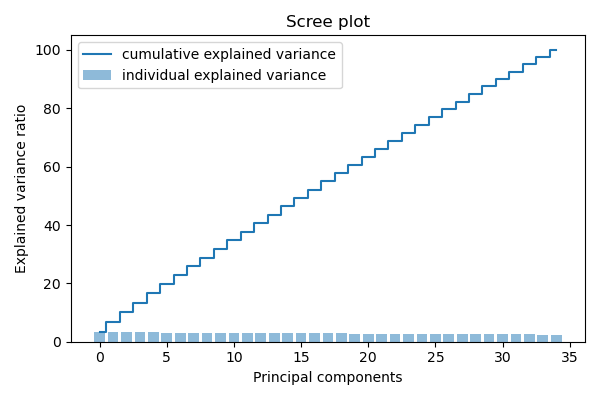

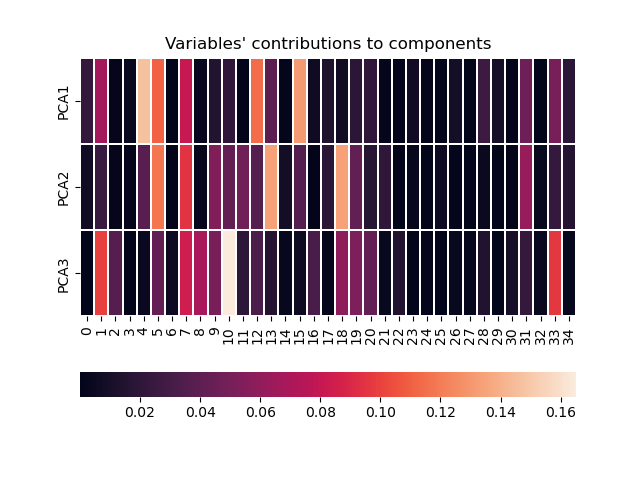

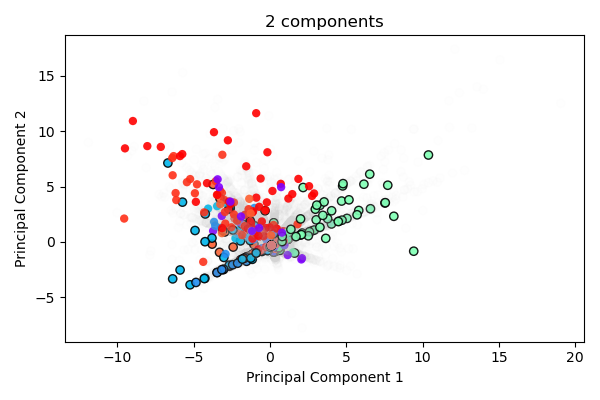

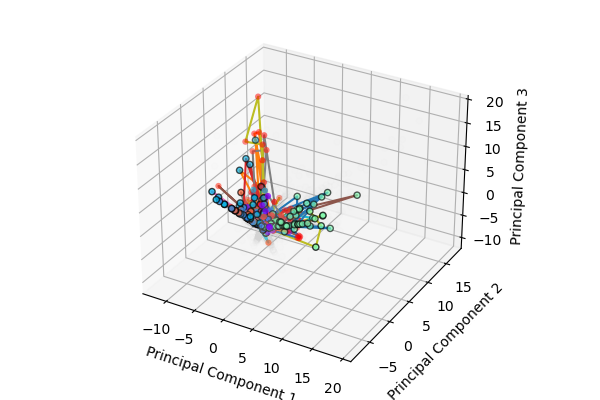

scan: 1    #cells: 21


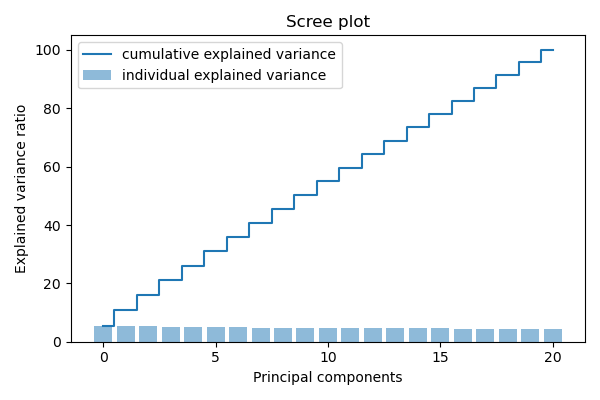

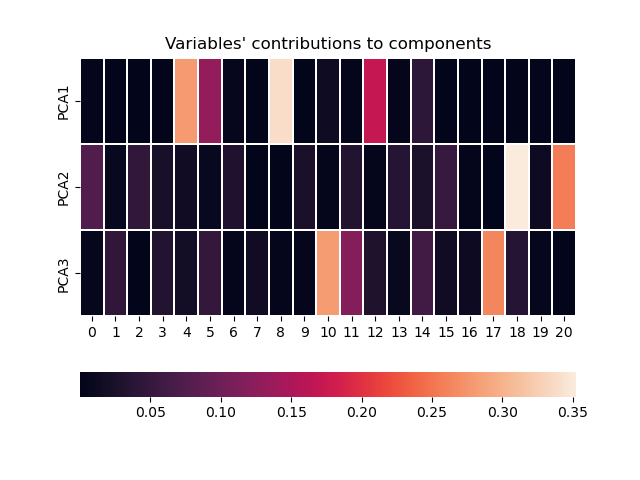

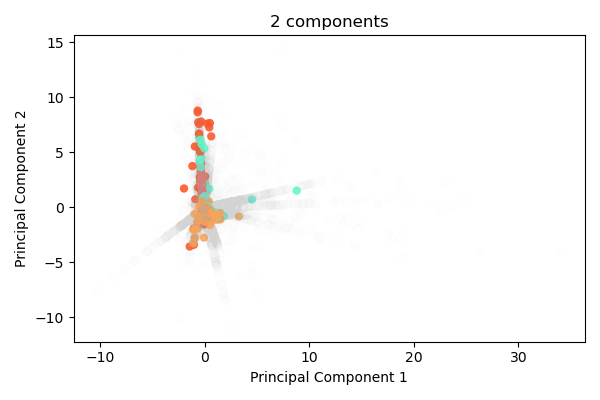

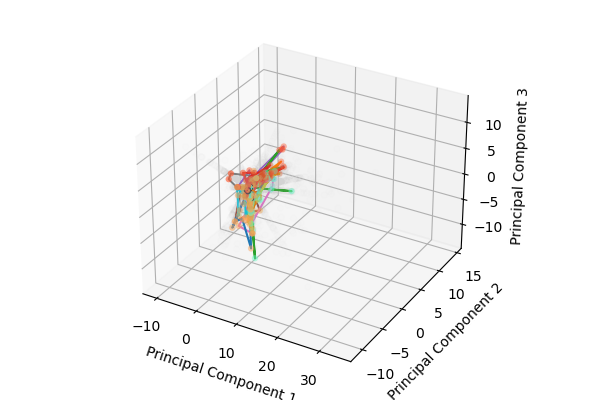

scan: 2    #cells: 22


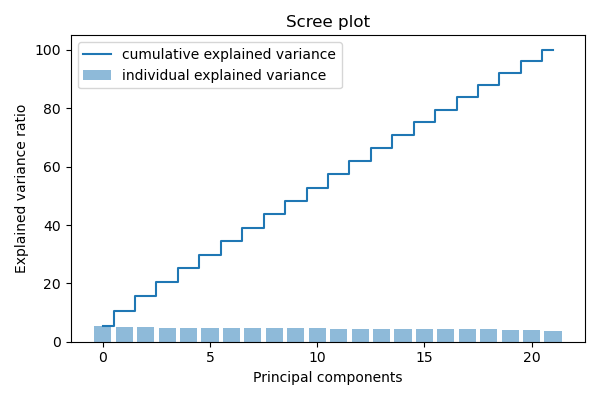

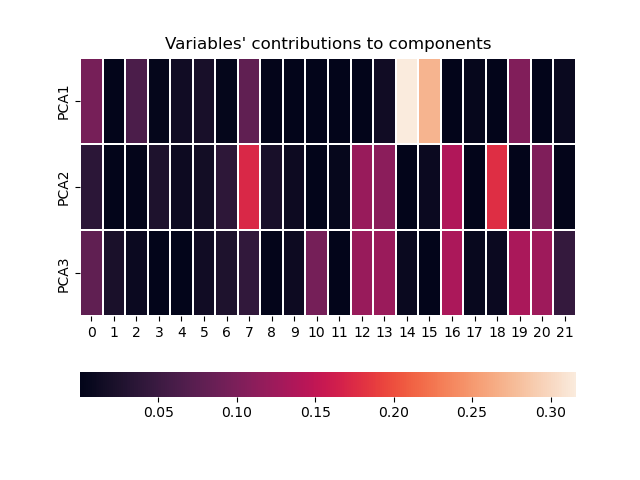

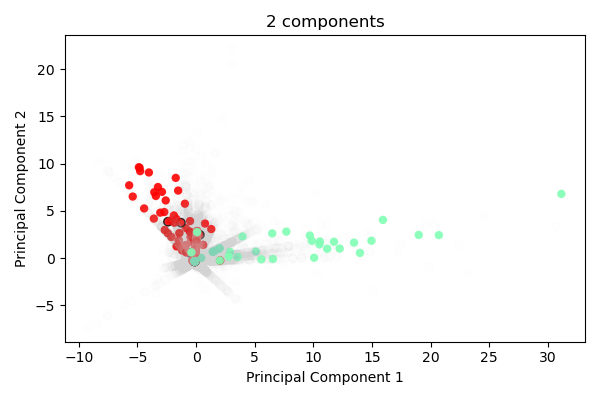

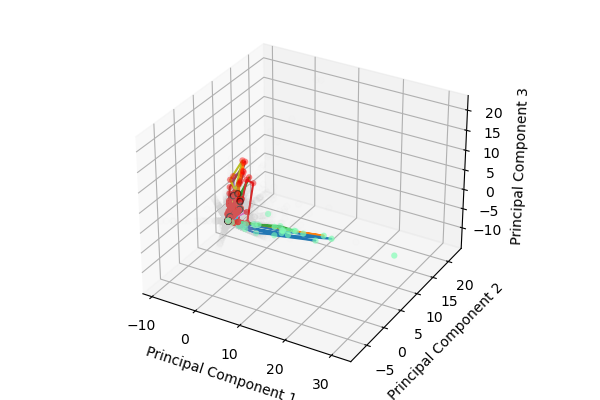

scan: 3    #cells: 22


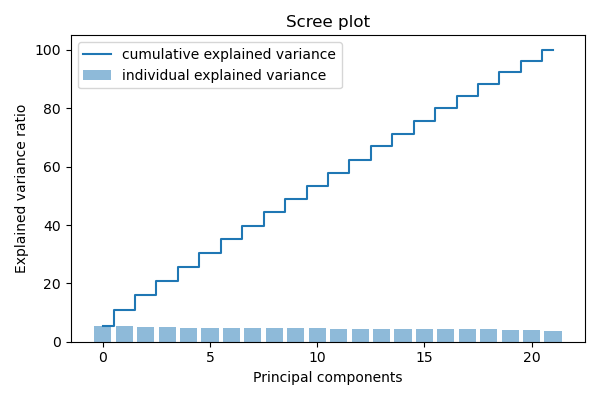

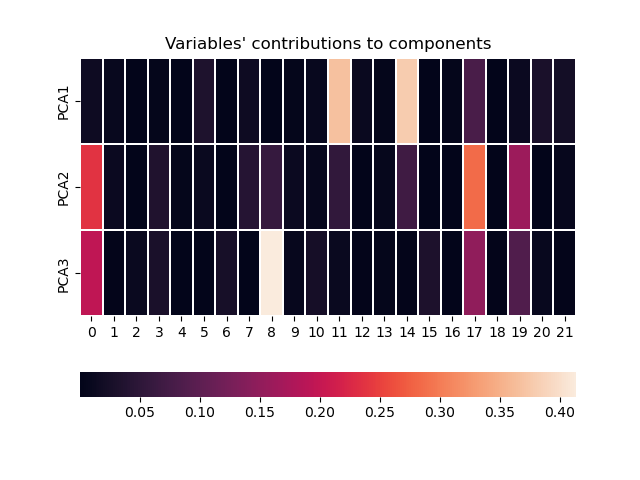

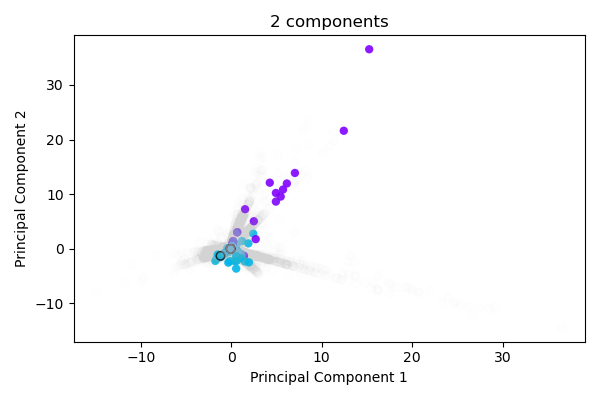

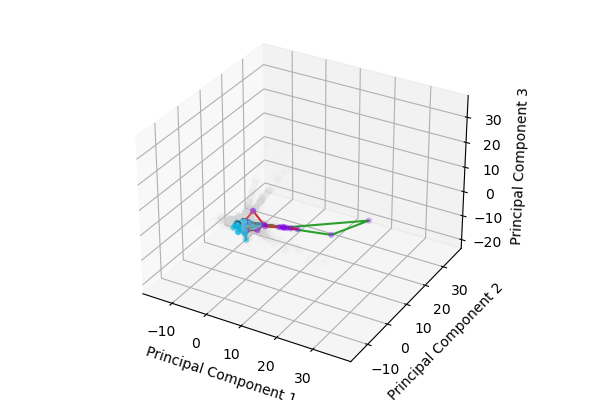

scan: 4    #cells: 12


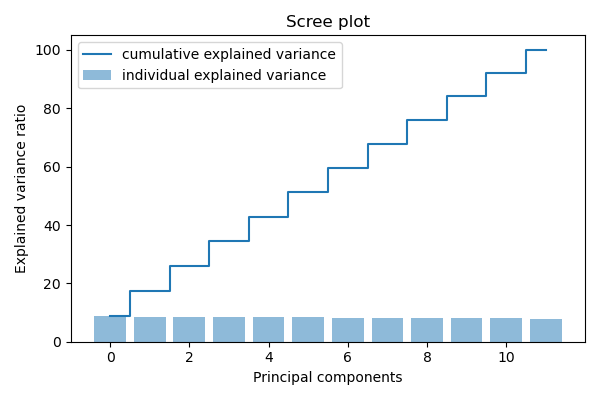

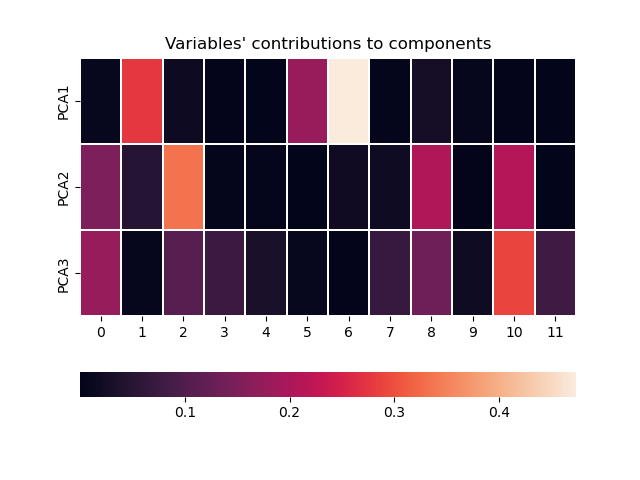

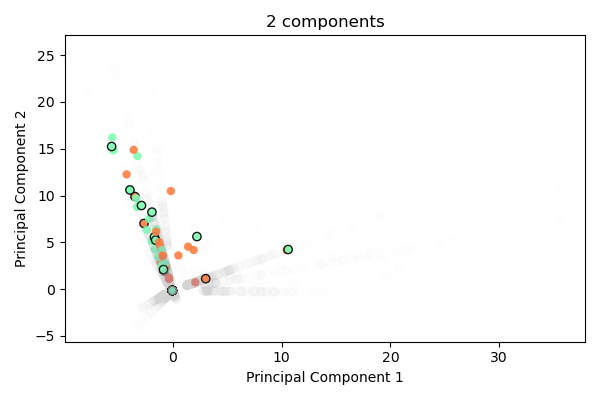

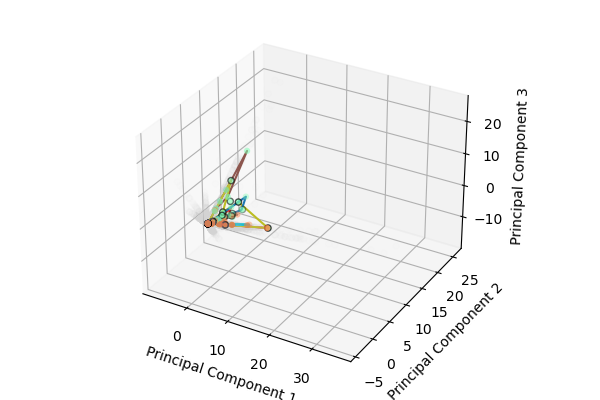

In [108]:
fig.clf()
plt.close()

Ypca = [] # one for each scan
for scan_id,scantraces in enumerate(traces): # by scan
    print("scan:",scan_id, "   #cells:",len(scantraces)) # N-dimensions
    scantraces = np.array(scantraces)
    # Standardize traces to help PCA yield a feature subspace maximizing the variance along the axes
    scantraces_std = StandardScaler().fit_transform(scantraces.T)
    # print(scantraces_std)
    
    # print('NumPy covariance matrix: \n%s' %np.cov(scantraces_std.T))
    cor_mat2 = np.corrcoef(scantraces)
    eig_vals, eig_vecs = np.linalg.eig(cor_mat2)
    # print('Eigenvectors \n%s' %eig_vecs)
    # print('\nEigenvalues \n%s' %eig_vals)
    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    tot = sum(eig_vals)
    var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    
    plt.figure(figsize=(6, 4))
    plt.title("Scree plot")
    plt.bar(range(len(scantraces)), var_exp, alpha=0.5, align='center', label='individual explained variance')
    plt.step(range(len(scantraces)), cum_var_exp, where='mid', label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    # matrix_w = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
    # print('Matrix W:\n', matrix_w)

    sklearn_pca = sklearnPCA(n_components=3)
    Y_sklearn = sklearn_pca.fit_transform(scantraces_std)
    Ypca.append( Y_sklearn )

    plt.figure()
    plt.title("Variables' contributions to components")
    _ = sns.heatmap(sklearn_pca.components_**2,
                 yticklabels=["PCA"+str(x) for x in range(1,sklearn_pca.n_components_+1)],
                 xticklabels=list(range(len(scantraces))),
                 linewidths=0.05,
                 cbar_kws={"orientation": "horizontal"})
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.title("2 components")
    plt.scatter(Y_sklearn[:,0], Y_sklearn[:,1], c=ecolors[scan_id], edgecolors=scolors[scan_id])
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(projection='3d')
    for linestart,lineend in elines[scan_id]:
        ax.plot(Y_sklearn[linestart:lineend,0], Y_sklearn[linestart:lineend,1], Y_sklearn[linestart:lineend,2])
    ax.scatter(Y_sklearn[:,0], Y_sklearn[:,1], Y_sklearn[:,2], c=ecolors[scan_id], edgecolors=scolors[scan_id])
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    plt.tight_layout()
    plt.show()


#### Testing cluster manifolds
To detemine if events from a cluster belonged to the same manifold, we determined how closely their trajectories overlapped in the reduced dimensional space of PCA by measuring the [Haussdorf distance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.directed_hausdorff.html) between pairs of state sequences (pairs of events) within a cluster containing several events.     
To establish the significance of these distances, we compared them to the distances between surrogate trajectories obtained by shuffling (100 times) the original trajectories.

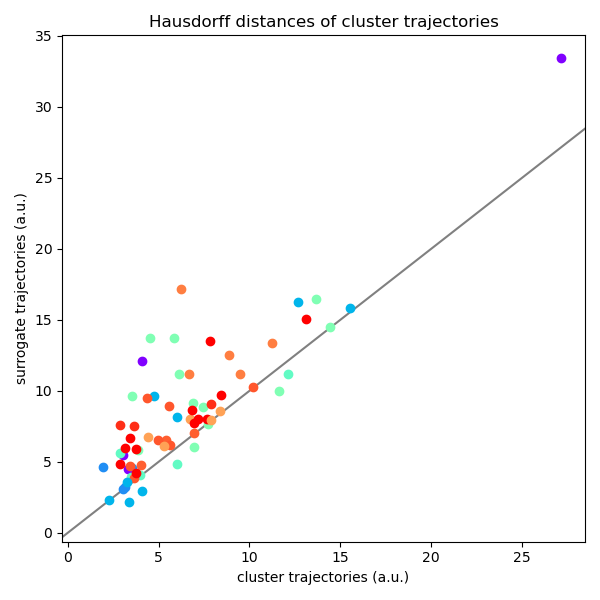

In [107]:
from scipy.spatial.distance import directed_hausdorff

# trajectories
hausdorff_trajectories = [None for i in range(5)] # list of dictionaries (below)
hausdorff_surrogates = [None for i in range(5)]
for scan_id in range(5):
    zippedlinescolors = sorted(zip(elines[scan_id],elinescolors[scan_id]), key = lambda t: t[1])
    currentcolor = None
    clustertrajectories = {}
    clustersurrogates = {} 
    for iline,_ in enumerate(zippedlinescolors[:-1]):
        (linestart1,lineend1),linecolor1 = zippedlinescolors[iline]
        (linestart2,lineend2),linecolor2 = zippedlinescolors[iline+1]
        if not currentcolor:
            currentcolor = linecolor1
        if currentcolor != linecolor2:
            currentcolor = linecolor2
            continue
        # trajectories
        u = np.array([ Ypca[scan_id][linestart1:lineend1,0], Ypca[scan_id][linestart1:lineend1,1], Ypca[scan_id][linestart1:lineend1,2] ]).T
        v = np.array([ Ypca[scan_id][linestart2:lineend2,0], Ypca[scan_id][linestart2:lineend2,1], Ypca[scan_id][linestart2:lineend2,2] ]).T
        # print(u.shape)
        if to_hex(currentcolor) not in clustertrajectories.keys():
            clustertrajectories[to_hex(currentcolor)] = []
        clustertrajectories[to_hex(currentcolor)].append( max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0]) ) # symmetric

        # surrogates
        hdistances = []
        nprng = np.random.default_rng()
        for si in range(100):
            us = nprng.permuted( u, axis=1 )
            vs = nprng.permuted( v, axis=1 )
            hdistances.append( max(directed_hausdorff(us, vs)[0], directed_hausdorff(vs, us)[0]) )
        if to_hex(currentcolor) not in clustersurrogates.keys():
            clustersurrogates[to_hex(currentcolor)] = []
        clustersurrogates[to_hex(currentcolor)].append( np.mean(hdistances) ) # symmetric

        # storage
    hausdorff_trajectories[scan_id] = clustertrajectories
    hausdorff_surrogates[scan_id] = clustersurrogates

# print(hausdorff_trajectories)
# print()
# print(hausdorff_surrogates)

# plotting 
fig.clf()
plt.close()
plt.figure(figsize=(6, 6))
plt.title("Hausdorff distances of cluster trajectories")
plt.axline((1, 1), slope=1, c='gray', zorder=1)
for trajectoriesdist,surrogatesdist in zip(hausdorff_trajectories,hausdorff_surrogates):
    for (trcolor,trdist),(sucolor,sudist) in zip(trajectoriesdist.items(), surrogatesdist.items() ):
        plt.scatter(trdist, sudist, c=trcolor)
plt.xlabel('cluster trajectories (a.u.)')
plt.ylabel('surrogate trajectories (a.u.)')
plt.tight_layout()
plt.show()